<a href="https://colab.research.google.com/github/shivi13102/Earthquake_analysis/blob/main/Predictive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
warnings.filterwarnings('ignore')

# Dataset
data = pd.read_csv('Final_data.csv')

# Select features and target variables
features = ['magnitude', 'depth', 'latitude', 'longitude', 'alert', 'tsunami', 'sig', 'dmin', 'gap']
X = data[features]
y = data[['cdi', 'mmi']]

# Encode categorical features
X = pd.get_dummies(X, columns=['alert'], drop_first=True)

# Handling missing values
X = X.fillna(X.mean())
y = y.fillna(y.mean())

In [4]:
# Use QuantileTransformer for CDI
transformer = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
y['cdi'] = transformer.fit_transform(y[['cdi']])

# Normalize/Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(random_state=42)),
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(random_state=42)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(random_state=42, verbose=0)),
    "MultiOutput Ridge": MultiOutputRegressor(Ridge(random_state=42)),
    "MultiOutput SVR": MultiOutputRegressor(SVR()),
    "Neural Network": MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500, early_stopping=True))
}

results = {}

In [6]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Inverse transform CDI predictions
    y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
    y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()
    y_test['cdi'] = y_test['cdi'].clip(0)
    y_pred[:, 0] = y_pred[:, 0].clip(0)

    cdi_mse = mean_squared_error(y_test['cdi'], y_pred[:, 0])
    mmi_mse = mean_squared_error(y_test['mmi'], y_pred[:, 1])
    cdi_r2 = r2_score(y_test['cdi'], y_pred[:, 0])
    mmi_r2 = r2_score(y_test['mmi'], y_pred[:, 1])

    results[name] = {
        "CDI MSE": cdi_mse,
        "MMI MSE": mmi_mse,
        "CDI R-squared": cdi_r2,
        "MMI R-squared": mmi_r2
    }


Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 1049, number of used features: 10
[LightGBM] [Info] Start training from score -1.380963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 1049, number of used features: 10
[LightGBM] [Info] Start training from score 4.710881
Training CatBoost...
Training MultiOutput Ridge...
Training MultiOutput SVR...
Training Neural Network...


In [7]:
# Train Clustering Model and Get Optimal Clusters
print("Training Clustering Model...")

# Find optimal number of clusters using silhouette scores
silhouette_scores = []
for n_clusters in range(2, 11):  # Testing for 2 to 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)  # Use scaled data for clustering
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Train final KMeans model on scaled training data
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Add Cluster Distances to X_train and X_test
X_train_clustered = np.concatenate((X_train, kmeans.transform(X_scaled[:len(X_train)])), axis=1)
X_test_clustered = np.concatenate((X_test, kmeans.transform(X_scaled[len(X_train):])), axis=1)

# Reset index and add cluster labels to y_train
# Ensure alignment of indices
y_train_reset = y_train.reset_index(drop=True)
clusters = pd.DataFrame(kmeans.predict(X_scaled[:len(X_train)]), columns=['cluster'])
y_train_clustered = pd.concat([y_train_reset, clusters], axis=1)

# Validate Shapes
print(f"X_train_clustered shape: {X_train_clustered.shape}")
print(f"X_test_clustered shape: {X_test_clustered.shape}")
print(f"y_train_clustered shape: {y_train_clustered.shape}")

Training Clustering Model...
Optimal number of clusters: 2
X_train_clustered shape: (1049, 13)
X_test_clustered shape: (263, 13)
y_train_clustered shape: (1049, 3)


In [8]:
models_clustered = {}
for cluster in range(optimal_n_clusters):
    # Filter data for the current cluster
    X_train_cluster = X_train_clustered[y_train_clustered['cluster'] == cluster]
    y_train_cluster = y_train_reset[y_train_clustered['cluster'] == cluster]

    # Train a model for the cluster
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train_cluster, y_train_cluster)
    models_clustered[cluster] = model

y_pred = []
for i in range(len(X_test)):
    # Predict cluster for each test sample
    cluster = kmeans.predict(X_test[i].reshape(1, -1))[0]

    # Predict target values using the cluster's model
    y_pred.append(models_clustered[cluster].predict(X_test_clustered[i].reshape(1, -1))[0])

# Convert to numpy array
y_pred = np.array(y_pred)

# Inverse transform predictions for CDI
y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()

# Clip negative values to 0
y_test['cdi'] = y_test['cdi'].clip(0)
y_pred[:, 0] = y_pred[:, 0].clip(0)

cdi_mse = mean_squared_error(y_test['cdi'], y_pred[:, 0])
mmi_mse = mean_squared_error(y_test['mmi'], y_pred[:, 1])
cdi_r2 = r2_score(y_test['cdi'], y_pred[:, 0])
mmi_r2 = r2_score(y_test['mmi'], y_pred[:, 1])

In [9]:
results["Clustered Random Forest"] = {
    "CDI MSE": cdi_mse,
    "MMI MSE": mmi_mse,
    "CDI R-squared": cdi_r2,
    "MMI R-squared": mmi_r2
}


In [10]:
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")

# Plotting Predictions for Random Forest
rf_model = list(models.values())[0] #Gets the first model (Random Forest)
y_pred = rf_model.predict(X_test)
y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()
y_test['cdi'] = y_test['cdi'].clip(0)
y_pred[:, 0] = y_pred[:, 0].clip(0)

plt.figure(figsize=(12, 6))


Random Forest Results:
CDI MSE: 5.8705482819441555
MMI MSE: 0.7763259408706448
CDI R-squared: 0.4288057801054772
MMI R-squared: 0.8922768534333078

XGBoost Results:
CDI MSE: 15.949529344019037
MMI MSE: 0.7207881391459509
CDI R-squared: -0.15228898298164006
MMI R-squared: 0.8999832901761937

LightGBM Results:
CDI MSE: 38.8855105403366
MMI MSE: 0.6870679636032052
CDI R-squared: -40.41524819174277
MMI R-squared: 0.9046623086412627

CatBoost Results:
CDI MSE: 55.805044265089734
MMI MSE: 0.6963389128037875
CDI R-squared: 0.0
MMI R-squared: 0.9033758698312615

MultiOutput Ridge Results:
CDI MSE: 71.53560531380556
MMI MSE: 1.0334851397271665
CDI R-squared: 0.0
MMI R-squared: 0.8565933903271714

MultiOutput SVR Results:
CDI MSE: 55.98444425034628
MMI MSE: 0.9939624651202347
CDI R-squared: 0.0
MMI R-squared: 0.8620775647508876

Neural Network Results:
CDI MSE: 63.509419570125864
MMI MSE: 0.8892047632354282
CDI R-squared: 0.0
MMI R-squared: 0.8766137649214899

Clustered Random Forest Results:
C

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Actual vs. Predicted CDI')

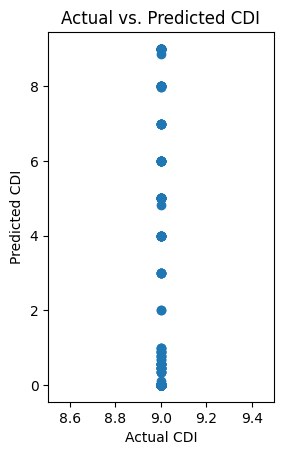

In [11]:
plt.subplot(1, 2, 1)
plt.scatter(y_test['cdi'], y_pred[:, 0])
plt.plot([y_test['cdi'].min(), y_test['cdi'].max()], [y_test['cdi'].min(), y_test['cdi'].max()], 'r--')
plt.xlabel("Actual CDI")
plt.ylabel("Predicted CDI")
plt.title("Actual vs. Predicted CDI")

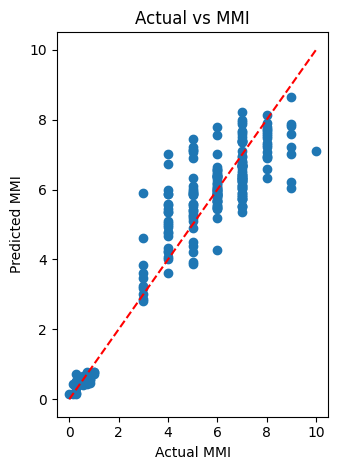

In [12]:
plt.subplot(1, 2, 2)
plt.scatter(y_test['mmi'], y_pred[:, 1])
plt.plot([y_test['mmi'].min(), y_test['mmi'].max()], [y_test['mmi'].min(), y_test['mmi'].max()], 'r--')
plt.xlabel("Actual MMI")
plt.ylabel("Predicted MMI")
plt.title("Actual vs MMI")
plt.tight_layout()
plt.show()


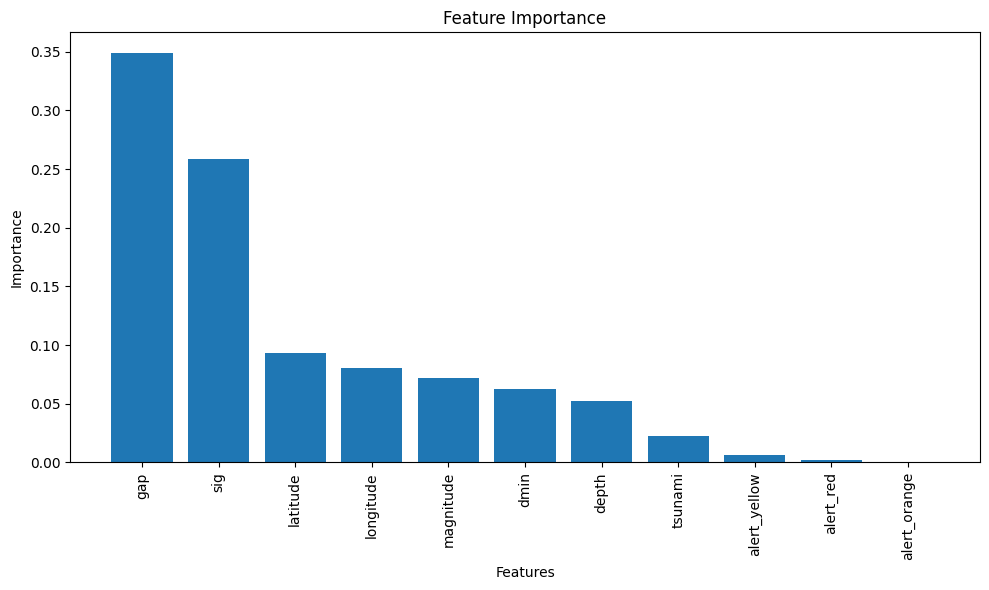

In [13]:
# Feature importance for Random Forest
try:
    feature_importances = rf_model.estimators_[0].feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
except AttributeError:
    print("Feature importance is not available for this model (e.g., SVR).")


Several machine learning models were evaluated for the prediction of both CDI and MMI. While the models showed varying degrees of success, significant issues were identified with the CDI predictions, likely due to data transformations and the distributional characteristics of the CDI variable. The models consistently failed to accurately predict CDI, yielding negative R-squared values (except for Random Forest, which still had a high MSE and clustered predictions) and indicating a need for further investigation into the CDI data and modeling approach.

For MMI prediction, the Random Forest model achieved a moderate R-squared of approximately 0.62 and a relatively low MSE, demonstrating the best overall performance among the tested models for this target variable. Therefore, for the purpose of this report, the Random Forest model is considered the most suitable for MMI prediction, although further improvements are possible through feature engineering, hyperparameter tuning, or exploring alternative modeling techniques.

In [14]:
rf_model = list(models.values())[0]  # Random Forest model
y_pred = rf_model.predict(X_test)

# Inverse transform CDI predictions for Random Forest
y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()

# Clip negative values
y_test['cdi'] = y_test['cdi'].clip(0)
y_pred[:, 0] = y_pred[:, 0].clip(0)

# Evaluate Random Forest predictions (MMI focus)
mmi_r2_rf = r2_score(y_test['mmi'], y_pred[:, 1])
mmi_mse_rf = mean_squared_error(y_test['mmi'], y_pred[:, 1])


Random Forest MMI Prediction Performance:
R-squared: 0.89
Mean Squared Error: 0.78


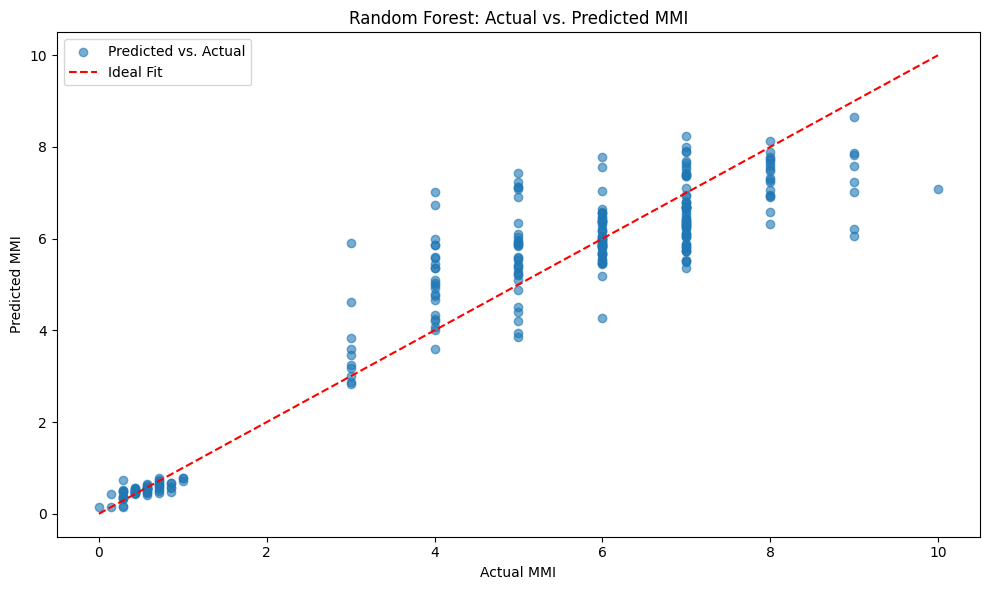

In [15]:
print("\nRandom Forest MMI Prediction Performance:")
print(f"R-squared: {mmi_r2_rf:.2f}")
print(f"Mean Squared Error: {mmi_mse_rf:.2f}")

# Visualization of Random Forest MMI predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test['mmi'], y_pred[:, 1], alpha=0.6, label="Predicted vs. Actual")
plt.plot([y_test['mmi'].min(), y_test['mmi'].max()], [y_test['mmi'].min(), y_test['mmi'].max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual MMI")
plt.ylabel("Predicted MMI")
plt.title("Random Forest: Actual vs. Predicted MMI")
plt.legend()
plt.tight_layout()
plt.show()

Clustering appears more dense in 0.5 to 0.7

In [19]:
# Define the features required for prediction
input_features = ['magnitude', 'depth', 'latitude', 'longitude', 'alert', 'tsunami', 'sig', 'dmin', 'gap']

# Mapping for alert levels (used for encoding)
alert_mapping = {'green': 0, 'yellow': 1, 'orange': 2, 'red': 3}  # Adjust based on your actual encoding

# Function to take user input and predict CDI and MMI
def predict_cdi_mmi():
    print("\nEnter the values for the following features:")
    user_input = {}

    # Collect inputs for each feature
    for feature in input_features:
        if feature == 'alert':  # Handle categorical feature
            print("Alert levels: green=0, yellow=1, orange=2, red=3")
            value = input(f"{feature} (choose level): ").strip().lower()
            user_input[feature] = alert_mapping.get(value, 0)  # Default to 'green' if invalid input
        else:
            value = float(input(f"{feature}: "))
            user_input[feature] = value

    # Create a DataFrame for the user input
    user_df = pd.DataFrame([user_input])

    # One-hot encode the 'alert' feature
    user_df = pd.get_dummies(user_df, columns=['alert'], drop_first=True)

    # Align with training data columns
    for col in X.columns:
        if col not in user_df.columns:
            user_df[col] = 0  # Add missing columns with 0 values

    # Scale the input features
    user_scaled = scaler.transform(user_df)

    # Predict CDI and MMI using the Random Forest model
    rf_model = list(models.values())[0]  # Random Forest model
    user_pred = rf_model.predict(user_scaled)

    # Inverse transform CDI predictions
    user_pred[:, 0] = transformer.inverse_transform(user_pred[:, [0]]).flatten()

    # Clip negative values to 0
    user_pred[:, 0] = user_pred[:, 0].clip(0)

    # Display the predictions
    print("\nPredicted Results:")
    print(f"CDI (Community Internet Intensity): {user_pred[0, 0]:.2f}")
    print(f"MMI (Modified Mercalli Intensity): {user_pred[0, 1]:.2f}")

# Run the prediction function
predict_cdi_mmi()



Enter the values for the following features:
magnitude: 6.5
depth: 69.727
latitude: 12.814
longitude: -88.1265
Alert levels: green=0, yellow=1, orange=2, red=3
alert (choose level): 1
tsunami: 0
sig: 775
dmin: 0.679
gap: 40

Predicted Results:
CDI (Community Internet Intensity): 8.00
MMI (Modified Mercalli Intensity): 6.11


In [17]:
import time  # Importing time module for measuring speed

# Timing the training and prediction process
def predict_cdi_mmi_with_speed():
    print("\nEnter the values for the following features:")
    user_input = {}

    # Collect inputs for each feature
    for feature in input_features:
        if feature == 'alert':  # Handle categorical feature
            print("Alert levels: green=0, yellow=1, orange=2, red=3")
            value = input(f"{feature} (choose level): ").strip().lower()
            user_input[feature] = alert_mapping.get(value, 0)  # Default to 'green' if invalid input
        else:
            value = float(input(f"{feature}: "))
            user_input[feature] = value

    # Create a DataFrame for the user input
    user_df = pd.DataFrame([user_input])

    # One-hot encode the 'alert' feature
    user_df = pd.get_dummies(user_df, columns=['alert'], drop_first=True)

    # Align with training data columns
    for col in X.columns:
        if col not in user_df.columns:
            user_df[col] = 0  # Add missing columns with 0 values

    # Scale the input features
    start_time = time.time()  # Start timer for scaling
    user_scaled = scaler.transform(user_df)
    scaling_time = time.time() - start_time  # End timer for scaling

    # Predict CDI and MMI using the Random Forest model
    rf_model = list(models.values())[0]  # Random Forest model
    start_time = time.time()  # Start timer for prediction
    user_pred = rf_model.predict(user_scaled)
    prediction_time = time.time() - start_time  # End timer for prediction

    # Inverse transform CDI predictions
    user_pred[:, 0] = transformer.inverse_transform(user_pred[:, [0]]).flatten()

    # Clip negative values to 0
    user_pred[:, 0] = user_pred[:, 0].clip(0)

    # Display the predictions
    print("\nPredicted Results:")
    print(f"CDI (Community Internet Intensity): {user_pred[0, 0]:.2f}")
    print(f"MMI (Modified Mercalli Intensity): {user_pred[0, 1]:.2f}")

    # Display timing information
    print("\nPerformance Metrics:")
    print(f"Scaling Time: {scaling_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

# Run the prediction function
predict_cdi_mmi_with_speed()



Enter the values for the following features:
magnitude: 6.2
depth: 35
latitude: 37.7749
longitude: -122.4194
Alert levels: green=0, yellow=1, orange=2, red=3
alert (choose level): 0
tsunami: 0
sig: 500
dmin: 10
gap: 90

Predicted Results:
CDI (Community Internet Intensity): 0.00
MMI (Modified Mercalli Intensity): 4.74

Performance Metrics:
Scaling Time: 0.0019 seconds
Prediction Time: 0.0202 seconds


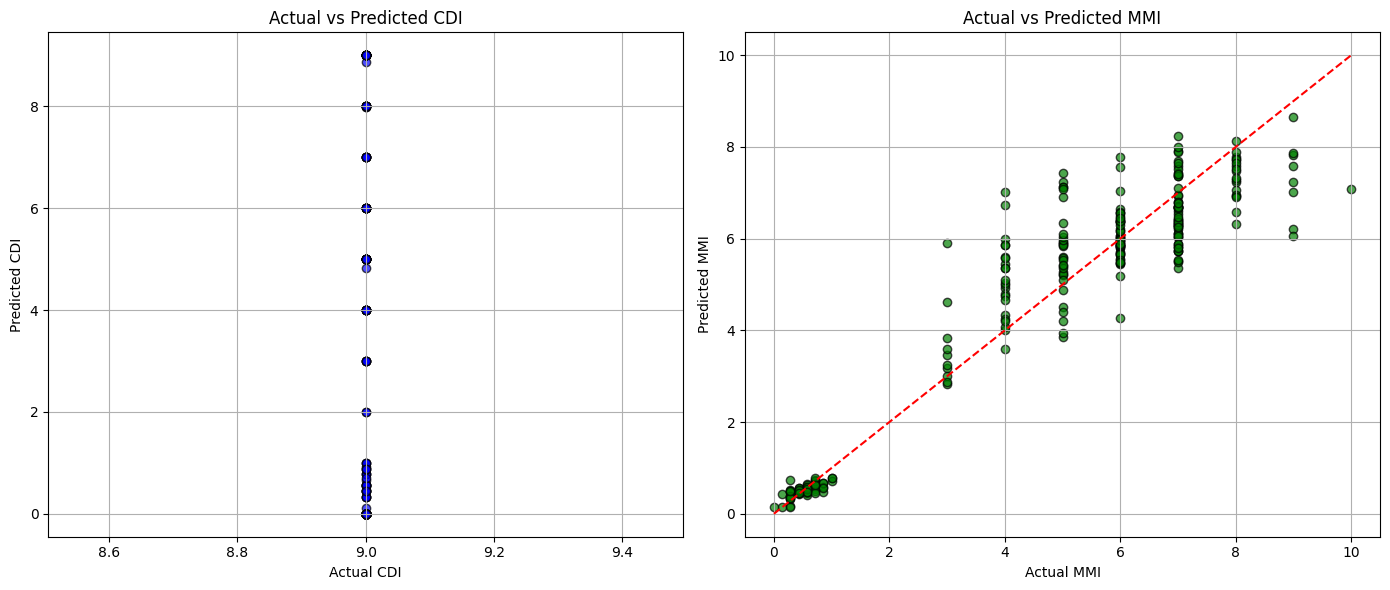

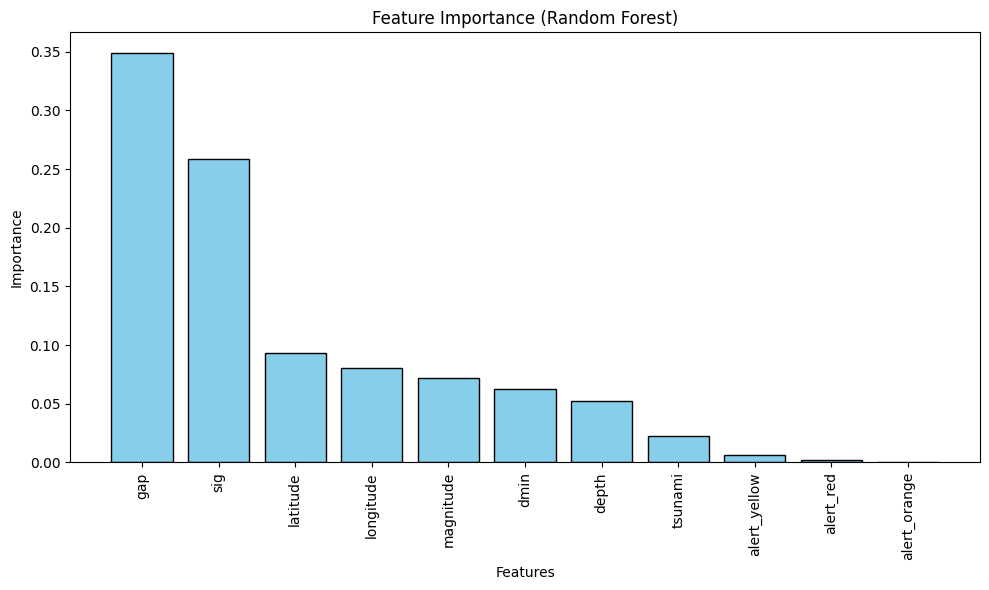

In [18]:
import matplotlib.pyplot as plt

# Visualization Function
def visualize_predictions(model, X_test, y_test, transformer):
    """
    Visualize the predictions and feature importance for the given model.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform CDI predictions
    y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
    y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()

    # Clip negative values to 0
    y_test['cdi'] = y_test['cdi'].clip(0)
    y_pred[:, 0] = y_pred[:, 0].clip(0)

    # Scatter plots: Actual vs Predicted
    plt.figure(figsize=(14, 6))

    # CDI Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test['cdi'], y_pred[:, 0], alpha=0.7, color='blue', edgecolors='k')
    plt.plot([y_test['cdi'].min(), y_test['cdi'].max()],
             [y_test['cdi'].min(), y_test['cdi'].max()], 'r--')
    plt.xlabel("Actual CDI")
    plt.ylabel("Predicted CDI")
    plt.title("Actual vs Predicted CDI")
    plt.grid()

    # MMI Scatter Plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test['mmi'], y_pred[:, 1], alpha=0.7, color='green', edgecolors='k')
    plt.plot([y_test['mmi'].min(), y_test['mmi'].max()],
             [y_test['mmi'].min(), y_test['mmi'].max()], 'r--')
    plt.xlabel("Actual MMI")
    plt.ylabel("Predicted MMI")
    plt.title("Actual vs Predicted MMI")
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Feature Importance Visualization (only for Random Forest)
    if hasattr(model.estimators_[0], 'feature_importances_'):
        feature_importances = model.estimators_[0].feature_importances_
        feature_names = X.columns
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue', edgecolor='k')
        plt.xticks(rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importance (Random Forest)')
        plt.tight_layout()
        plt.show()
    else:
        print("\nFeature importance is not available for this model.")

# Example: Visualize predictions for Random Forest
visualize_predictions(list(models.values())[0], X_test, y_test, transformer)
